# Homework 2
Student: Grigoryev Mikhail

Group: J4133c

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import math

from tqdm.notebook import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol

import openpyxl

from IPython.display import clear_output

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)

import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [18]:
data = pd.read_excel("age_data_2005.xlsx", sheet_name="both; 1950-2005, estimates")
data = data[data["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(drop=True)
GROUPS = [f"{k*5} - {(k+1)*5-1}" for k in range(20)] + ["100+"]
SR = [f"SR: {k*5} - {(k+1)*5-1}" for k in range(1,20)] + ["SR: 100+"]
YEARS = np.sort(data["Year"].unique())
data.loc[
    data["Year"].isin(YEARS[1:]),
    SR
] = data[
    data["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / data[
    data["Year"].isin(YEARS[:-1])
][GROUPS[:-1]].values

In [19]:
dataM = pd.read_excel("age_data_2005.xlsx", sheet_name="m; 1950-2005, estimates")
dataM = dataM[dataM["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(
    drop=True
)
dataM.loc[dataM["Year"].isin(YEARS[1:]), SR] = dataM[
    dataM["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / dataM[dataM["Year"].isin(YEARS[:-1])][GROUPS[:-1]].values

In [20]:
dataF = pd.read_excel("age_data_2005.xlsx", sheet_name="f; 1950-2005, estimates")
dataF = dataF[dataF["Region"]=="Russian Federation"].replace("-", np.nan).reset_index(
    drop=True
)
dataF.loc[dataF["Year"].isin(YEARS[1:]), SR] = dataF[
    dataF["Year"].isin(YEARS[1:])
][GROUPS[1:]].values / dataF[dataF["Year"].isin(YEARS[:-1])][GROUPS[:-1]].values

In [21]:
n1, n2 = 4, 8 # groups able to birth
dataF["FR"] = dataF[GROUPS[0]] / dataF[GROUPS[n1:n2]].sum(axis=1)

# Parameter ranges

In [22]:
SRmin, SRmax = [], []
for group in GROUPS[1:]:
    SRmin.append(min(dataM[f"SR: {group}"].min(), dataF[f"SR: {group}"].min()))
    SRmax.append(max(dataM[f"SR: {group}"].max(), dataF[f"SR: {group}"].max()))
SRmin = dict(zip(GROUPS[1:], SRmin))
SRmax = dict(zip(GROUPS[1:], SRmax))

In [23]:
FRmin, FRmax = dataF["FR"].min(), dataF["FR"].max()
print(f"Fertility rate min: {FRmin}\nFertility rate max: {FRmax}")

Fertility rate min: 0.1506880066319535
Fertility rate max: 0.32293923449506007


In [24]:
BGs = dataM[GROUPS[0]] / dataF[GROUPS[0]]
BGmin, BGmax = BGs.min(), BGs.max()
print(f"Boys/Girls min: {BGmin}\nBoys/Girls max: {BGmax}")

Boys/Girls min: 1.0325590968461564
Boys/Girls max: 1.0662600679886989


# Plotting Functions

In [25]:
def plot_sens(params, df):
    groups = [col.replace("FR_", "") for col in df.columns if "FR" in col]
    K = len(groups)
    fig, axs = plt.subplots(K, figsize=(20, 8*K))
    for it, group in enumerate(groups):   
        colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(params)))
        ax = axs[it]
        ax.set_title(f"age group: {group}", fontsize=25)
        for i, param in enumerate(params):
            ax.plot(df["year"], df[f"{param}_{group}"], linewidth=5, label=f"{param}", color=colors[i])
        ax.tick_params(axis="x", labelsize=18)
        ax.tick_params(axis="y", labelsize=18)
        ax.set_xlabel("Year", fontsize=18)
        ax.set_ylabel("S1", fontsize=18)
        ax.grid()
        ax.legend(fontsize=18)
    plt.show()

In [45]:
def plot_unce(output, num_lines, gigachads=[0.8, 0.5, 0.3]):
    colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(num_lines)))
    K = len(num_lines)
    fig, axs = plt.subplots(K, figsize=(20, 8*K))  
    for it, ids in enumerate(num_lines):
        try:
            ax = axs[it]
        except:
            ax = axs
        for i, k in enumerate(ids):
            color = colors[it]
            group = output["agegroups"][k]
            mean_ = output["datasets"][k,:,:].mean(axis=-2)
            ax.plot(output["year"], mean_, linewidth=5, label=f"{group}", color=color)
            for j, perc in enumerate(list(output["percentiles"].keys())):
                bottom = output["percentiles"][perc][k][0]
                top = output["percentiles"][perc][k][1]
                ax.fill_between(output["year"], bottom, top, color=color, alpha=gigachads[j],
                               label=f"{group}: {perc}% interval")
        ax.tick_params(axis="x", labelsize=18) 
        ax.tick_params(axis="y", labelsize=18) 
        ax.set_xlabel("Year", fontsize=18)
        ax.set_ylabel("Population", fontsize=18)
        ax.grid()
        ax.legend(fontsize=18)
    
    plt.show()

# Sensitivity analysis

In [27]:
def Model_sens(init_profile_F, init_profile_M, 
          #SRATES_F, SRATES_M, 
          SR, FR, BG, agegroup, init_year=2005, kmax=1):
    sratesF = SR
    sratesM = SR
    n1, n2 = 4, 8
    profile1M = init_profile_M
    profile1F = init_profile_F
    year = init_year
    for k in range(kmax):
        profile2F = np.zeros_like(profile1F) 
        profile2F[1:] = sratesF*profile1F[:-1]
        profile2F[0] = FR*(profile2F[n1:n2]).sum()
        profile1F = profile2F
        
        profile2M = np.zeros_like(profile1M)       
        profile2M[1:] = sratesM*profile1M[:-1]
        profile2M[0] = profile2F[0] * BG
        profile1M = profile2M
        
        year += 5
    profile = profile2F + profile2M
    return profile[GROUPS.index(agegroup)]

In [28]:
def Eval_sens(params_sets, model, leave=False, kwargs={}):
    results = []
    for params_set in tqdm(params_sets, total=len(params_sets), leave=leave):
        kwargs["SR"] = params_set[2:]
        kwargs["FR"] = params_set[0]
        kwargs["BG"] = params_set[1]
        results.append(model(**kwargs))
    return np.array(results)

In [29]:
def analyse_sens(agegroup, problem, kwargs, Model_sens, Eval, nvals=1000, max_time_steps=9, leave=False):
    results = []
    kwargs["agegroup"] = agegroup
    param_values = saltelli.sample(problem, nvals)
    Years = [kwargs["init_year"]]
    for kmax in tqdm(range(1, max_time_steps+1), leave=leave):  
        kwargs["kmax"] = kmax
        Years.append(Years[-1] + 5)
        Y = Eval_sens(param_values, Model_sens, kwargs=kwargs)
        Si = sobol.analyze(problem, Y, print_to_console=False)
        results.append(Si["S1"])
    results = np.array(results)
    results = dict(zip(problem["names"], results.T))
    results["year"] = Years[1:]
    return results

In [30]:
def full_analysis_sens(problem, kwargs, Model_sens, Eval_sens, nvals=1000, max_time_steps=9):
    results = pd.DataFrame()
    results["year"] = [kwargs["init_year"] + k*5 for k in range(1, max_time_steps+1)]
    kwargs["kmax"] = max_time_steps
    for agegroup in tqdm(GROUPS[1:GROUPS.index("45 - 49") + 1]):
        res = analyse_sens(agegroup, problem, kwargs, Model_sens, Eval_sens, nvals=nvals, max_time_steps=max_time_steps)
        for name in problem["names"]:
            results[f"{name}_{agegroup}"] = res[name]
    return results

In [31]:
n1, n2 = 4, 8
SRATES_F = dataF[dataF["Year"]==2005][SR].mean(axis=0).values
SRATES_M = dataM[dataM["Year"]==2005][SR].mean(axis=0).values
init_profile_F = dataF[dataF["Year"]==2005][GROUPS].values.reshape(-1)
init_profile_M = dataM[dataM["Year"]==2005][GROUPS].values.reshape(-1)
BG_ratio = (dataM[dataM["Year"]==2005][GROUPS[0]] / dataF[
    dataF["Year"]==2005
][GROUPS[0]]).values[0]
FR_coef = dataF["FR"][11]

In [32]:
names = ["FR", "BG"] + [f"SR({k})" for k in SRmin.keys()]
problem = {
    "num_vars": len(names),
    "names": names,
    "bounds": [[FRmin, FRmax], [BGmin, BGmax]]+list(zip(SRmin.values(), SRmax.values()))
}
kwargs = {"init_profile_F": init_profile_F, "init_profile_M": init_profile_M, 
           #"SRATES_F": SRATES_F, "SRATES_M": SRATES_M,
          "init_year": 2005}
S1 = full_analysis_sens(problem, kwargs, Model_sens, Eval_sens, nvals=1000, max_time_steps=9)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

In [33]:
S1.to_excel("S1.xlsx")
S1 = pd.read_excel("S1.xlsx")

In [34]:
for group in GROUPS:
    new = S1[[col for col in S1.columns if ("SR" in col) and (f"_{group}" in col)]].sum(axis=1)
    S1 = S1.drop([col for col in S1.columns if ("SR" in col) and (f"_{group}" in col)], axis=1)
    S1[f"SR_{group}"] = new

In [35]:
S1.head()

,Unnamed: 0,year,FR_5 - 9,BG_5 - 9,FR_10 - 14,BG_10 - 14,FR_15 - 19,BG_15 - 19,FR_20 - 24,BG_20 - 24,...,SR_55 - 59,SR_60 - 64,SR_65 - 69,SR_70 - 74,SR_75 - 79,SR_80 - 84,SR_85 - 89,SR_90 - 94,SR_95 - 99,SR_100+
0,0,2010,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2015,1.011578,0.000297,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2020,1.005531,0.000285,1.006487,0.000299,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2025,0.998151,0.000271,1.000454,0.000286,0.99445,0.000284,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2030,0.989913,0.000262,0.991610,0.000272,0.98447,0.000267,0.985041,0.000274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


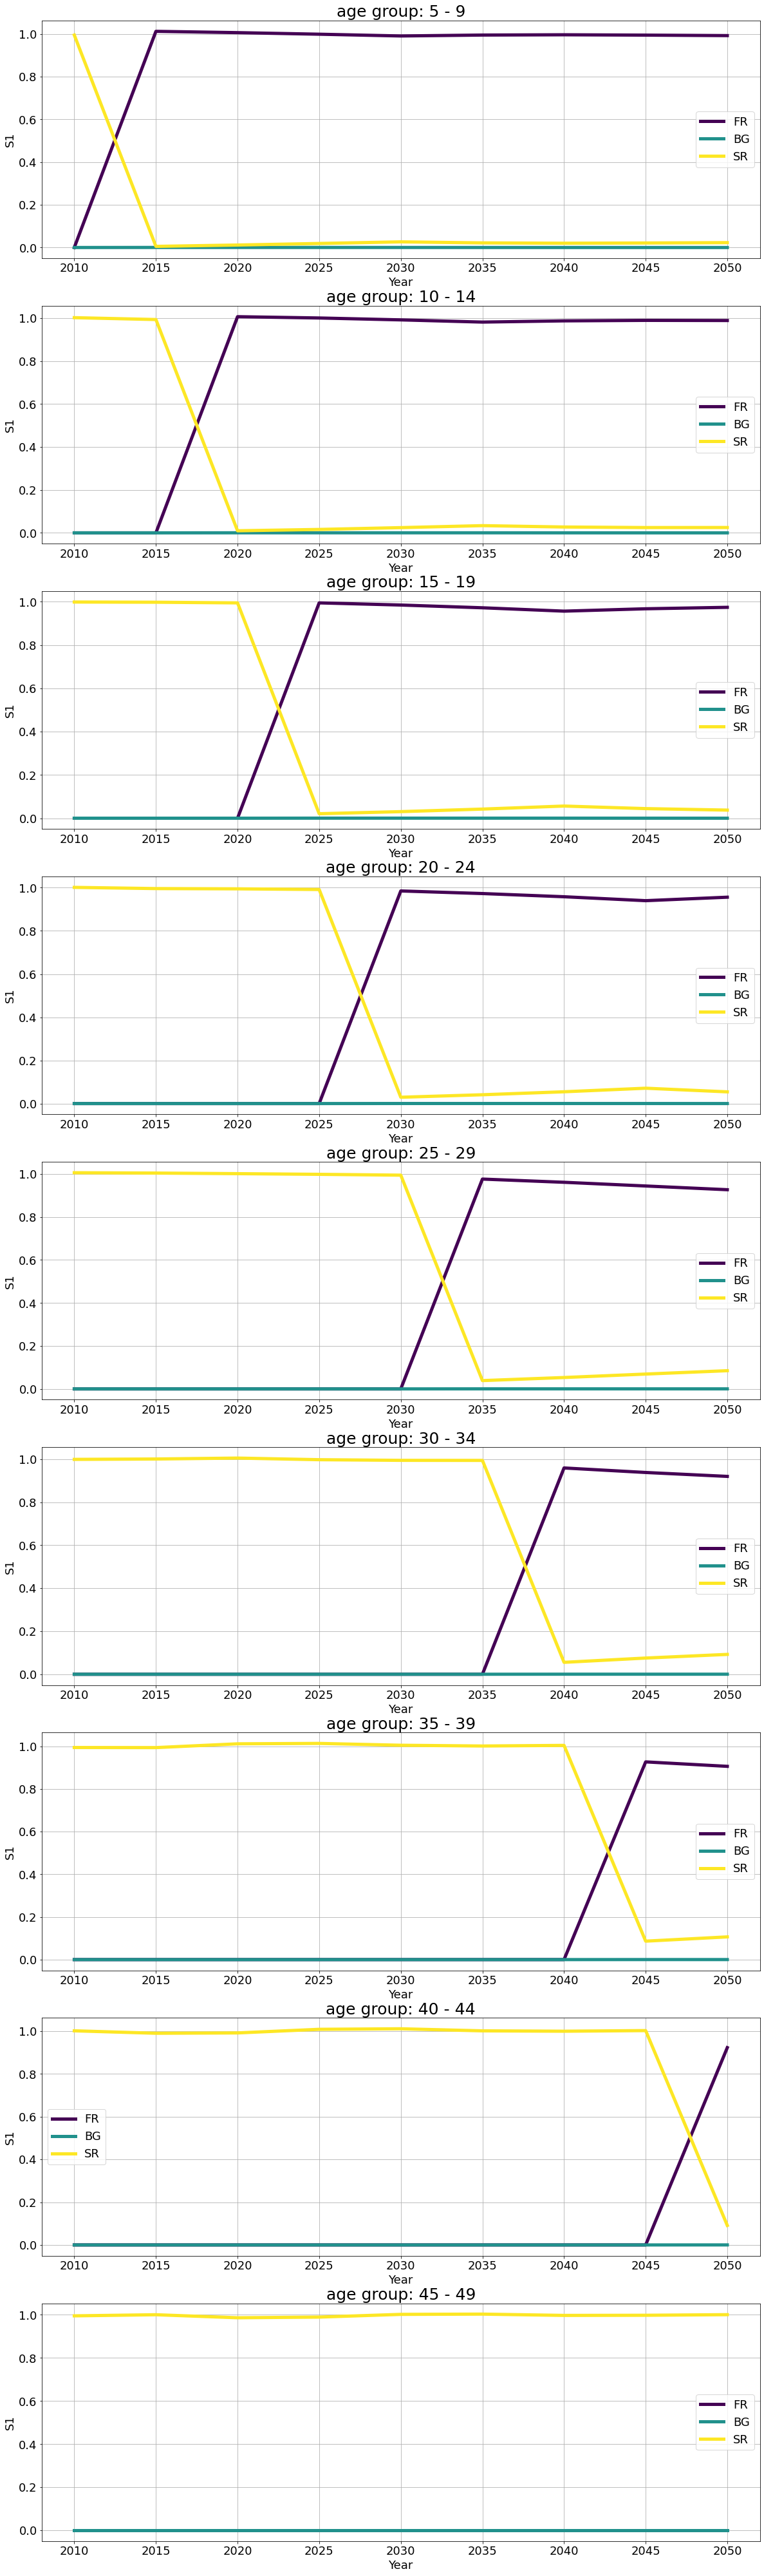

In [36]:
plot_sens(["FR", "BG", "SR"], S1)

## Uncertainty analysis

In [38]:
def Model_unce(init_profile_F, init_profile_M,
          SR, FR, BG, agegroup=None, init_year=2005, kmax=1):
    sratesF = SR
    sratesM = SR
    n1, n2 = 4, 8
    
    profiles = []
    profile1M = init_profile_M
    profile1F = init_profile_F
    for k in range(kmax):
        profile2F = np.zeros_like(profile1F) 
        profile2F[1:] = sratesF*profile1F[:-1]
        profile2F[0] = FR*(profile2F[n1:n2]).sum()
        profile1F = profile2F
        
        profile2M = np.zeros_like(profile1M)       
        profile2M[1:] = sratesM*profile1M[:-1]
        profile2M[0] = profile2F[0] * BG
        profile1M = profile2M    
        profiles.append(profile2F + profile2M)
    return np.array(profiles)[:, GROUPS.index(agegroup)]

In [39]:
def analyse_unce(agegroup, problem, kwargs, model, nvals=1000, max_time_steps=9, leave=False):
    Y = []    
    param_values = saltelli.sample(problem, nvals)
    kwargs["agegroup"] = agegroup
    kwargs["kmax"] = max_time_steps
    for v in tqdm(param_values, total=len(param_values), leave=leave):
        kwargs["FR"] = v[0]
        kwargs["BG"] = v[1]
        kwargs["SR"] = v[2:]
        Y.append(model(**kwargs))
    return np.array(Y)

In [40]:
def full_analysis_unce(agegroups, problem, kwargs, model, nvals=1000, max_time_steps=9, leave=True):
    results = {"datasets": [], "agegroups": agegroups, 
               "year": [kwargs["init_year"] + (k+1)*5 for k in range(max_time_steps)]}
    kwargs["kmax"] = max_time_steps
    for agegroup in tqdm(agegroups, leave=leave):
        Y = analyse_unce(agegroup, problem, kwargs, model, nvals=nvals, max_time_steps=max_time_steps)
        results["datasets"].append(Y)
    results["datasets"] = np.array(results["datasets"])
    return results

In [41]:
def compute_percentiles(dictionary, intervals):
    total = np.expand_dims(dictionary["datasets"].mean(axis=0), axis=0)
    dictionary["datasets"] = np.concatenate([dictionary["datasets"], total], axis=0)
    dictionary["agegroups"].append("total")
    dictionary["percentiles"] = {}
    for i in intervals:
        dictionary["percentiles"][f"{i}"] = [np.percentile(data, [50-i/2,50+i/2], axis=0) for data in dictionary["datasets"]]   
    return dictionary    

In [42]:
names = ["FR", "BG"] + [f"SR({k})" for k in SRmin.keys()]
problem = {"num_vars": len(names), "names": names, 
           "bounds": [[FRmin, FRmax], [BGmin, BGmax]]+list(zip(SRmin.values(), SRmax.values()))}
kwargs = {"init_profile_F": init_profile_F, "init_profile_M": init_profile_M, "init_year": 2005}
agegroups = GROUPS[1:GROUPS.index("40 - 44")+1]
output = full_analysis_unce(agegroups, problem, kwargs, Model_unce, nvals=1000, max_time_steps=20)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

In [43]:
output2 = compute_percentiles(output, [50, 70, 90])

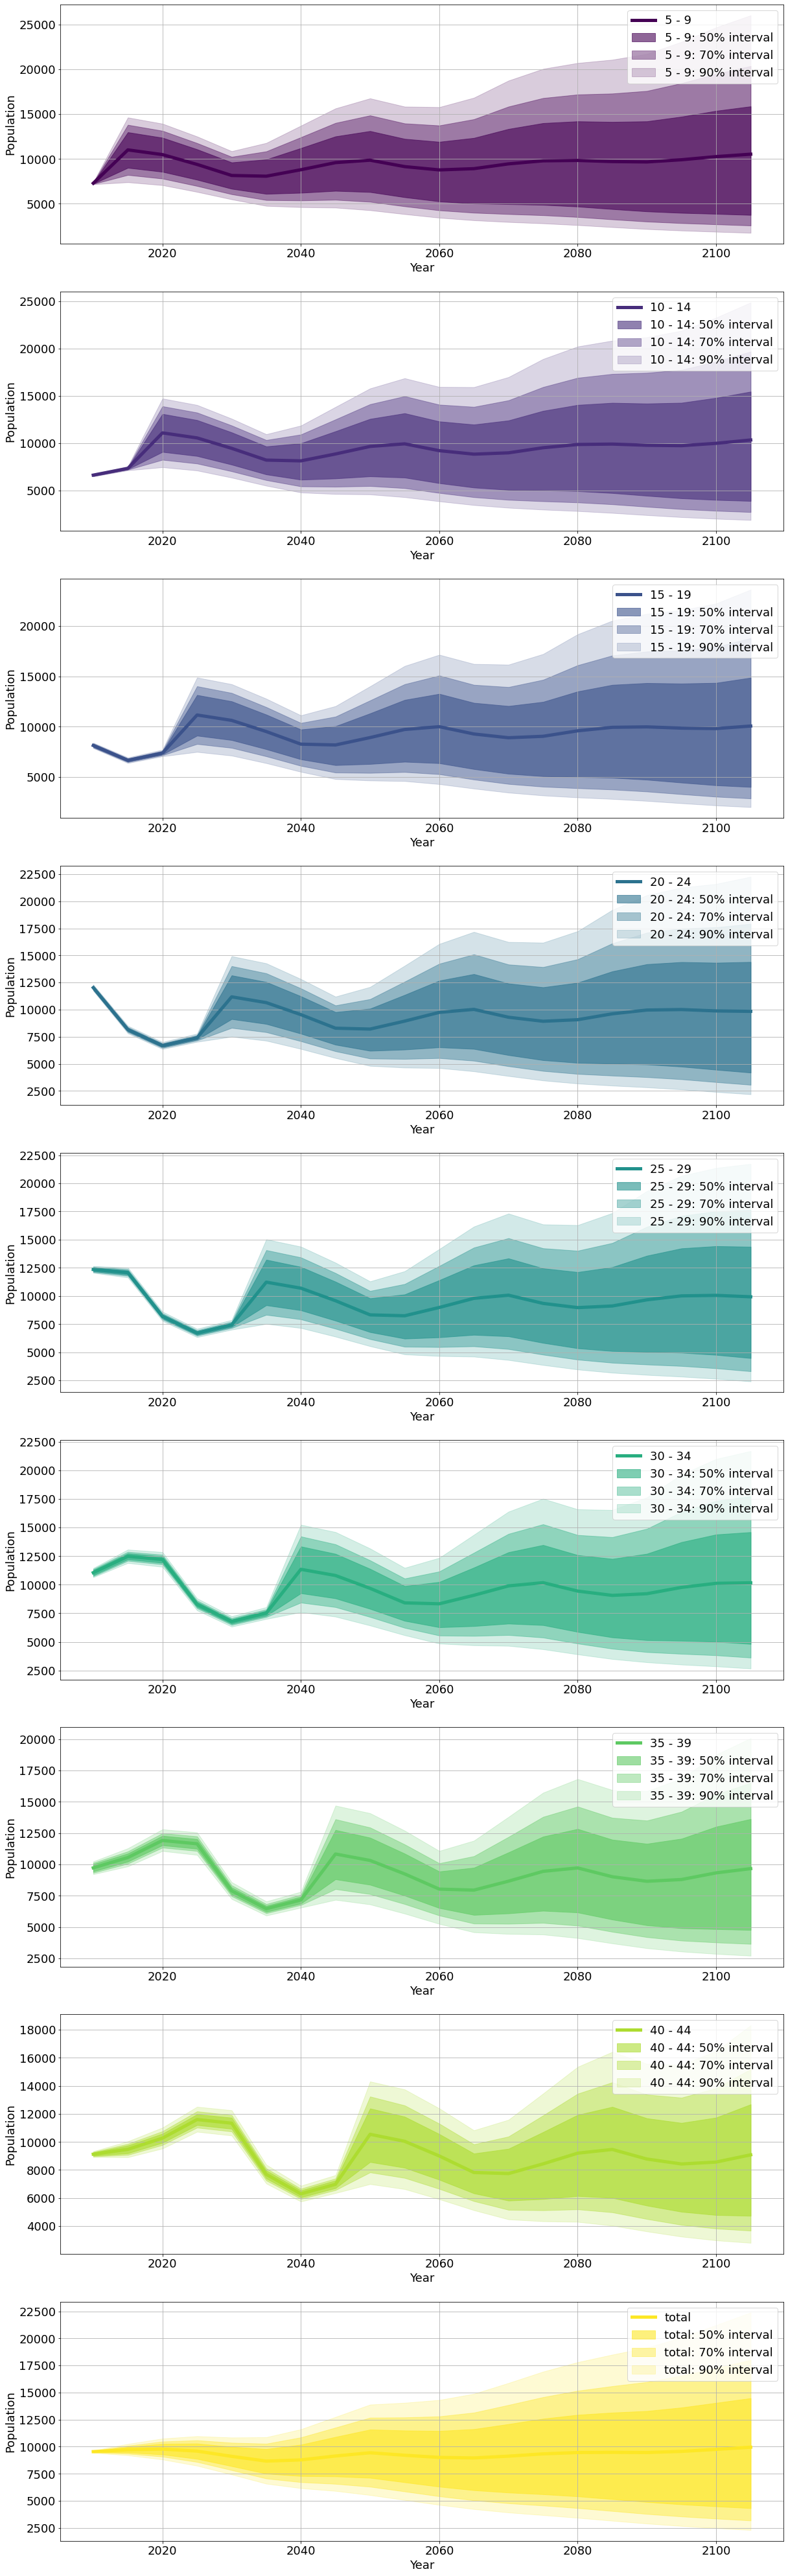

In [46]:
plot_unce(output2, [[k] for k in range(len(output["agegroups"]))], gigachads=[0.6, 0.4, 0.2])